This notebook describes how to run GWAS between germline (and somatic) variants and DepMap dependencies.

Most of the code in this notebook is for pre-processing the CCLE data to get it ready for GWAS. It can definitely be optimized in the future so that it is much faster. Maybe once I get a little bit more time I can do that.

# Set up the environment

In [2]:
#Arguments/Parameters

working_dir = '/home/jupyter/notebooks/Ancestry' #home directory for this workspace
workspace_bucket = Sys.getenv('WORKSPACE_BUCKET') #the workspace bucket that we will upload the output to

In [3]:
#Load packages
library(tidyverse)
library(genefu)
library(qqman)
library(ggtext)

#Define functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: survcomp

Loading required package: survival

Loading required package: prodlim

Loading required package: biomaRt

Loading required package: iC10

Loading required package: pamr

Loading required package: cluster

Loading required package: impute

Loading required package: iC10TrainingData

Loading required package: AIMS

Loading required package: e1071

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clust

In [95]:
#Create directory structure

system(glue::glue("
if [ ! -d '{working_dir}/software' ] 
then
mkdir {working_dir}/software
fi

if [ ! -d 'mkdir {working_dir}/gwas' ] 
then
mkdir {working_dir}/gwas
fi

if [ ! -d 'mkdir {working_dir}/gwas/gwas_output' ] 
then
mkdir {working_dir}/gwas/gwas_output
fi


if [ ! -d 'mkdir {working_dir}/output' ] 
then
mkdir {working_dir}/output
fi


if [ ! -d 'mkdir {working_dir}/raw_data' ] 
then
mkdir {working_dir}/raw_data
fi
"))

In [4]:
#Download and unpack PLINK

system(glue::glue("
mkdir {working_dir}/software/plink2
cd {working_dir}/software/plink2
wget https://s3.amazonaws.com/plink2-assets/plink2_linux_avx2_20210826.zip
unzip plink2_linux_avx2_20210826.zip
"))


system(glue::glue("
mkdir {working_dir}/software/plink
cd {working_dir}/software/plink
wget https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20210606.zip
unzip plink_linux_x86_64_20210606.zip
"))

In [5]:
#Download and install bcftools
#Install bcftools
step_install_bcftools <- !file.exists(glue::glue("{working_dir}/software/bcftools/bcftools"))

if(step_install_bcftools) {
system(glue::glue("
cd {working_dir}/software
git clone --recurse-submodules git://github.com/samtools/htslib.git
git clone git://github.com/samtools/bcftools.git
cd bcftools
autoheader && autoconf && ./configure --enable-libgsl --enable-perl-filters
make
export BCFTOOLS_PLUGINS=/home/jupyter-user/notebooks/Ancestry/software/bcftools/plugins
")) } else {print("bcftools is already installed")}

[1] "bcftools is already installed"


In [6]:
#install tabix to the appropriate directory. for now just use tabix from my ancestry workspace

# Download and pre-process the data


In [7]:
#Download a bed file with all of the human exons and a second bed file with all of the introns
system(glue::glue("
cd {working_dir}/gwas
gsutil cp gs://fc-7211fd5c-103b-4f7b-831a-1f2def618f62/exon_positions .
mv exon_positions filtering.bed
"))

In [10]:
#filter the ccle vcf file so that it only includes variants in exons
system(glue::glue("
cd {working_dir}/gwas
cp {working_dir}/raw_data/depmap/avana14/hg38.ccle.all.called.vcf.gz . 
/home/jupyter/notebooks/Ancestry/software/tabix-0.2.6/tabix -p vcf hg38.ccle.all.called.vcf.gz
{working_dir}/software/bcftools/bcftools view -R {working_dir}/gwas/filtering.bed hg38.ccle.all.called.vcf.gz -o filtered.ccle.all.called.hg38.vcf.gz -Oz
/home/jupyter/notebooks/Ancestry/software/tabix-0.2.6/tabix -p vcf filtered.ccle.all.called.hg38.vcf.gz
"))

The sample names in the vcf file are currently cell line names eg "UACC62_SKIN_CANCER" or something like that. We want to convert them so that they are the ACH IDs.

We also want to filter the dataset so that it only includes samples that we have CRISPR screening data for.

In [55]:
#Extract the sample header
system(glue::glue("
cd {working_dir}/gwas
{working_dir}/software/bcftools/bcftools view -h filtered.ccle.all.called.hg38.vcf.gz -o sample.header.txt
head -n 32 sample.header.txt | tail -n 1 | tr -d '#' > sample.header.for.r.txt
rm sample.header.txt
"))

#Format a dataset where each new "CDS ID" sample header is on a new row, then write it.
paste(working_dir, "/gwas", sep = "") %>% setwd()
sample.header <- read.table('sample.header.for.r.txt', sep = "\t") %>%
pull(V1)

split.row = data.frame(strsplit(sample.header, " ")) %>%
rename("data" = 1) %>%
pull(data) %>%
tail(-8) %>%
gsub(".*/", "", .) %>%
gsub('_cnn_filtered.vcf.gz', '', .) %>%
head(-5) %>%
gsub(";", "", .) 



#Now we need to convert the CDS ID so that it is an ACH ID

#Download a file to bridge between the CDS ID and the ACH ID
system(glue::glue("
cd {working_dir}/gwas
gsutil cp gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514/ccle_sample_tracker.csv .
"))
paste(working_dir, "/gwas", sep = "") %>% setwd()
cds.to.ach <- read.table('ccle_sample_tracker.csv', sep = ",", header = T) %>%
filter(datatype %in% c("wgs", "wes"))


#Then create a vector of new sample names
new.sample.names = split.row %>%
plyr::mapvalues(from = cds.to.ach$cds_id, to = cds.to.ach$arxspan_id, warn_missing = FALSE)

#Some of the sample names have non-unique values (duplicate samples with both WES and WGS). Rename the duplicates
new.sample.names = new.sample.names %>% rename.duplicate(sep = "_", verbose = FALSE)
new.sample.names = new.sample.names$new.x


#Finally, create a vector of samples that we want to keep.
#These samples will have both CRISPR screening data and WES/WGS data

#Download the depmap chronos scores
system(glue::glue("
cd {working_dir}/gwas
gsutil cp gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514/CRISPR_gene_effect.csv .
"))
#Load the chronos scores and format it
paste(working_dir, "/gwas", sep = "") %>% setwd() #set the working directory
chronos.lines <- read.table('CRISPR_gene_effect.csv', sep = ",", header = T) %>%
pull(DepMap_ID) %>% 
unique()

#Filter new.sample.names so that it only includes cell lines that have been CRISPR screened
samples.to.keep = new.sample.names[new.sample.names %in% chronos.lines] %>% 
unique()


#Write out both of the files so that we can rename/filter the vcf
write.table(new.sample.names, "new.sample.names", sep = "\t", col.names = F, row.names = F, quote = F)
write.table(samples.to.keep, "samples.to.keep", sep = "\t", col.names = F, row.names = F, quote = F)

In [56]:
#Re-name the sample names in the vcf
system(glue::glue("
cd {working_dir}/gwas
rm renamed.hg38.ccle.all.called.vcf.gz
rm renamed.hg38.ccle.all.called.vcf.gz.tbi
{working_dir}/software/bcftools/bcftools reheader --samples new.sample.names -o renamed.hg38.ccle.all.called.vcf.gz filtered.ccle.all.called.hg38.vcf.gz
{working_dir}/software/tabix-0.2.6/tabix -p vcf renamed.hg38.ccle.all.called.vcf.gz
"))

In [57]:
#Then filter it so that it only includes the CRISPR screening samples
system(glue::glue("
cd {working_dir}/gwas
rm weswgs.hg38.ccle.all.called.vcf.gz
rm weswgs.hg38.ccle.all.called.vcf.gz.tbi
{working_dir}/software/bcftools/bcftools view -S samples.to.keep --force-samples -o weswgs.hg38.ccle.all.called.vcf.gz renamed.hg38.ccle.all.called.vcf.gz
{working_dir}/software/tabix-0.2.6/tabix -p vcf weswgs.hg38.ccle.all.called.vcf.gz
"))

Variants at the same position are grouped together right now. So we should un-group them.

For example:

Current format: chr1 // pos123456789 // ref=A // alt=G/T

New format: chr1 // pos123456789 // ref=A // alt=G chr1 // pos123456789 // ref=A // alt=T

In [104]:
#split the genotype calls
show_msg("Splitting Genotype Calls")
system(glue::glue("
cd {working_dir}/gwas
{working_dir}/software/bcftools/bcftools norm -m - weswgs.hg38.ccle.all.called.vcf.gz -o split.hg38.ccle.all.called.vcf.gz
{working_dir}/software/tabix-0.2.6/tabix -p vcf split.hg38.ccle.all.called.vcf.gz
"))

[1] "Splitting Genotype Calls"


In [57]:
#recode the ./. variants to 0/0
system(glue::glue("
cd {working_dir}/gwas
export PATH=$PATH:{working_dir}/software/bcftools
export BCFTOOLS_PLUGINS='{working_dir}/software/bcftools/plugins'
{working_dir}/software/bcftools/bcftools +setGT split.hg38.ccle.all.called.vcf.gz -o complete.hg38.ccle.all.called.vcf.gz -- -t . -n 0
{working_dir}/software/tabix-0.2.6/tabix -p vcf complete.hg38.ccle.all.called.vcf.gz
"))

In [58]:
#Format the dataset in the PLINK format
system(glue::glue("
cd {working_dir}/gwas
{working_dir}/software/plink2/plink2 --allow-extra-chr --vcf complete.hg38.ccle.all.called.vcf.gz --make-bed --out complete.hg38.ccle.all.called
"))

# GWAS and GWAS accessories


In [59]:
#Perform PCA for GWAS covariate
system(glue::glue("
cd {working_dir}/gwas
{working_dir}/software/plink2/plink2 --allow-extra-chr --bfile complete.hg38.ccle.all.called --pca 10 --out complete.hg38.ccle.all.called.pca10
"))

In [60]:
#Format the cell covariates

#Download the DepMap sample annotation file 
system(glue::glue("
cd {working_dir}/gwas
gsutil cp gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514/internal-21q3_v15-sample-info.csv .
"))

#Load in the sample annotation file
paste(working_dir, "/gwas", sep = "") %>% setwd()
cell.annotation <- read.table('internal-21q3_v15-sample-info.csv', sep = ",", fill = TRUE, header = TRUE) #Load in the sample header that contains all of the samples in the vcf file

#Format the covariates file
covariates <- cbind(cell.annotation$DepMap_ID, cell.annotation$lineage) %>% data.frame
colnames(covariates) <- c("ach_id", "lineage")


write.table(covariates, "cell.covariates.txt", sep = "\t", col.names = T, row.names = F, quote = F)

In [61]:
#Load in both of the covariate files and then merge them together into a single .cov file that is in the correct format
paste(working_dir, "/gwas", sep = "") %>% setwd() #set the working directory
pca.cov <- read.table('complete.hg38.ccle.all.called.pca10.eigenvec', sep = "\t", fill = TRUE) #Covariates from PCA
pca.cov <- pca.cov[,-1] #Remove the first column from pca.cov since we don't care about it
lineage.cov <- read.table('cell.covariates.txt', sep = "\t", fill = TRUE, header = TRUE) #Covariates from annotation file


#Assign the column names to pca.cov
colnames(pca.cov) <- c("ach_id", "pc1", "pc2", "pc3", "pc4", "pc5", "pc6", "pc7", "pc8", "pc9", "pc10")

#Convert the tumor types into numbers so that we can add it to the covariates file
unique.lineage <- lineage.cov$lineage %>% unique()
lineage.numbers <- seq(from = 1, to = length(unique.lineage), by = 1)
lineage.encoding <- cbind(unique.lineage, lineage.numbers) %>% data.frame()
colnames(lineage.encoding) <- c("lineage", "number")
lineage.cov$lineage <- plyr::mapvalues(lineage.cov$lineage, from = lineage.encoding$lineage, to = lineage.encoding$number)



#merge the two datasets together
pca.lineage.cov <- merge(pca.cov, lineage.cov, by = "ach_id")


#format the .cov file
covariate.file <- pca.lineage.cov
colnames(covariate.file)[1] <- c("IID")


#write the covariate file
write.table(covariate.file, "depmap.cov", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [62]:
#Get a vector of all of the ancestry-associated genes.
paste(working_dir, "/ccle_ancestry_analysis", sep = "") %>% setwd() #set the working directory
ancestry.associated.genes = read.table('ancestry_chronos_logistic_correlations.txt', sep = "\t", header = T) %>%
mutate(fdr_afr = p.adjust(pval_afr, method = "BH", n = n())) %>%
mutate(fdr_amr = p.adjust(pval_amr, method = "BH", n = n())) %>%
mutate(fdr_eas = p.adjust(pval_eas, method = "BH", n = n())) %>%
mutate(fdr_eur = p.adjust(pval_eur, method = "BH", n = n())) %>%
mutate(fdr_sas = p.adjust(pval_sas, method = "BH", n = n())) %>%
filter(fdr_afr < 0.05 | fdr_amr < 0.05 | fdr_eas < 0.05 | fdr_eur < 0.05 | fdr_sas < 0.05) %>%
pull(gene)

In [63]:
#Format the phenotype file

#Download the depmap chronos scores
system(glue::glue("
cd {working_dir}/gwas
gsutil cp gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514/CRISPR_gene_effect.csv .
"))

#Load the chronos scores and format it
paste(working_dir, "/gwas", sep = "") %>% setwd() #set the working directory
chronos.scores <- read.table('CRISPR_gene_effect.csv', sep = ",", header = F)
colnames(chronos.scores) = sub(" .*", "", chronos.scores[1,]) #Remove all of the junk after the gene name
chronos.scores <- chronos.scores[-1,] #Remove the old 'col.names' row.
colnames(chronos.scores)[1] <- "IID" #Convert the column name for the first column to IID, as per the formatting requirements for the .pheno file
chronos.scores[chronos.scores == ""] <- 0 #Replace the missing values with 0. Clearly not the best solution, but it is A solution. And these are rare cases, so it shouldn't affect it too much.   


#Now filter it so that it only includes the ancestry-associated genes 
genes.to.keep = intersect(colnames(chronos.scores), ancestry.associated.genes)
chronos.scores = chronos.scores %>%
dplyr::select(IID, all_of(genes.to.keep))


#write the phenotype.file
write.table(chronos.scores, "chronos_gwas_phenotypes.pheno", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

# Run GWAS!

In [71]:
#Run GWAS!!!
system(glue::glue("
cd {working_dir}/gwas
{working_dir}/software/plink2/plink2 --allow-extra-chr --bfile complete.hg38.ccle.all.called --maf 0.01 --logistic hide-covar --pfilter 1 --covar 'iid-only' depmap.cov --pheno chronos_gwas_phenotypes.pheno --out {working_dir}/gwas/gwas_output/gwas_out
"))

,chr,pos,pval,pos_add,pos_cum
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,69270,0.7550950,0,69270
2,1,69428,0.7583960,0,69428
3,1,69511,0.7736260,0,69511
4,1,69761,0.6304750,0,69761
5,1,69897,0.8219330,0,69897
6,1,930314,0.0989064,0,930314


,chr,pos,pval,pos_add,pos_cum
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
70178,22,50714943,0.1253640,2819165667,2869880610
70179,22,50738306,0.4310350,2819165667,2869903973
70180,22,50744827,0.1981880,2819165667,2869910494
70181,22,50744993,0.0200758,2819165667,2869910660
70182,22,50782306,0.4915910,2819165667,2869947973
70183,22,50798897,0.2645070,2819165667,2869964564


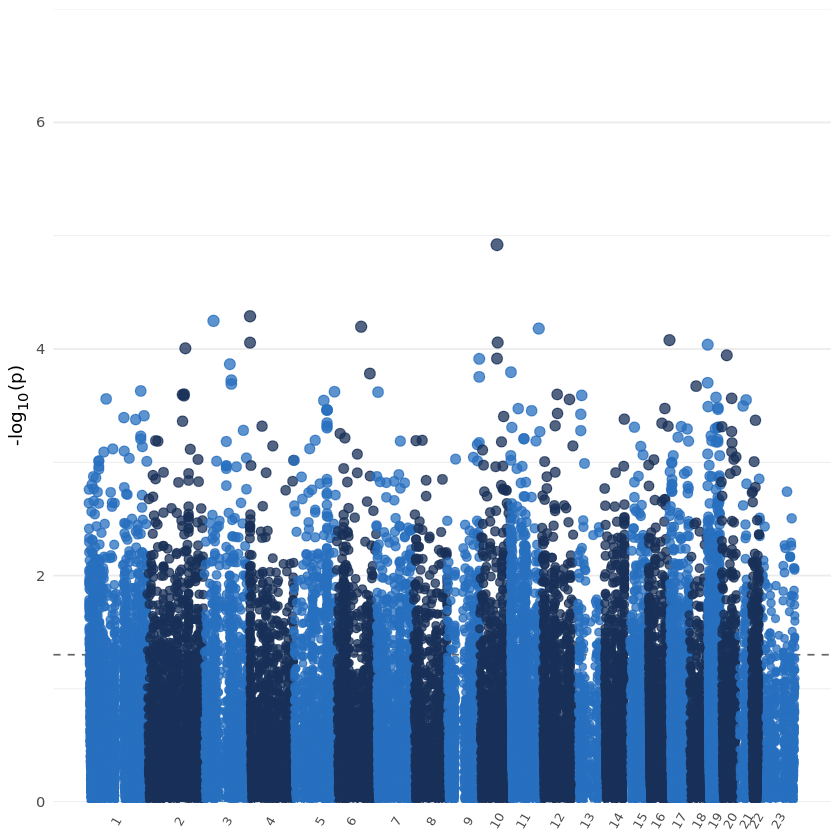

In [72]:
###GWAS seemed to work. Next step, make a manhattanplot
###Crap code, fix later

chromosomes = c(seq(from = 1, to = 22, by = 1), "X")

setwd('/home/jupyter/notebooks/Ancestry/gwas/gwas_output')
gwas.data = read.table('gwas_out.CLSPN.glm.linear', sep = "\t", header = F) %>%
rename("chr" = 1, "pos" = 2, "pval" = 12) %>%
dplyr::select(chr, pos, pval) %>%
filter(chr %in% chromosomes) %>%
mutate(chr = gsub("X", 23, chr)) %>%
mutate_all(function(x) as.numeric(as.character(x)))
           
       
data_cum <- gwas.data %>% 
  group_by(chr) %>% 
  summarise(max_pos = max(pos)) %>% 
  mutate(pos_add = lag(cumsum(max_pos), default = 0)) %>% 
  dplyr::select(chr, pos_add)

gwas.data <- gwas.data %>% 
  inner_join(data_cum, by = "chr") %>% 
  mutate(pos_cum = pos + pos_add)  
           
           
head(gwas.data)
tail(gwas.data)
           
           
axis_set <- gwas.data %>% 
group_by(chr) %>% 
summarize(center = mean(pos_cum))

ylim <- gwas.data %>% 
filter(pval == min(pval)) %>% 
mutate(ylim = abs(floor(log10(pval))) + 2) %>% 
pull(ylim)            
           
           
           
           
gwas.data %>%           
ggplot(aes(x = pos_cum, y = -log10(pval), 
                                  color = as_factor(chr), size = -log10(pval))) +
  geom_hline(yintercept = -log10(0.05), color = "grey40", linetype = "dashed") + 
  geom_point(alpha = 0.75) +
  scale_x_continuous(label = axis_set$chr, breaks = axis_set$center) +
  scale_y_continuous(expand = c(0,0), limits = c(0, ylim)) +
  scale_color_manual(values = rep(c("#276FBF", "#183059"), unique(length(axis_set$chr)))) +
  scale_size_continuous(range = c(0.5,3)) +
  labs(x = NULL, 
       y = "-log<sub>10</sub>(p)") + 
  theme_minimal() +
  theme( 
    legend.position = "none",
    panel.border = element_blank(),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
    axis.title.y = element_markdown(),
    axis.text.x = element_text(angle = 60, size = 8, vjust = 0.5)
  )
           


In [ ]:
#####NOTES FOR WHAT TO DO NEXT.

#CONSIDER IMPUTING MISSING SNPS